In [1]:
#import needed libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from time import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import ADASYN
sns.set()
%matplotlib inline
import warnings
warning = [DeprecationWarning, FutureWarning, UserWarning]
for w in warning:
    warnings.filterwarnings("ignore", category=w)

Using TensorFlow backend.


In [262]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [251]:
#Let's look what is the size of the datasets 
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (200000, 202)
Test Shape: (200000, 201)


In [252]:
pd.set_option('display.max_columns', None) #display all columns
pd.set_option('display.max_rows', None) #display all rows
train.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [255]:
test.head(10)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-

In [253]:
# Total number of records
n_records = len(train)

# Number of records where the client made the transaction
made = train.target.sum()

# Number of records where the client didn't make the transaction
didnt_make = n_records - made

# Percentage of transaction made
percentage = made / n_records 

# Print the results
print("Total number of records: {}".format(n_records))
print("Clients that made the transaction: {}".format(made))
print("Clients that didn't make the transaction: {}".format(didnt_make))
print("Percentage of clients that made the transaction: {}%".format(percentage*100))

Total number of records: 200000
Clients that made the transaction: 20098
Clients that didn't make the transaction: 179902
Percentage of clients that made the transaction: 10.049%


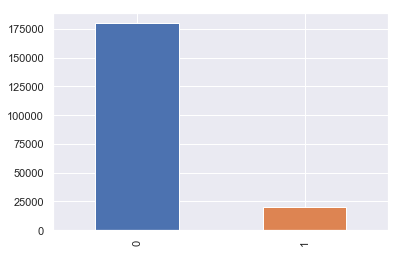

In [254]:
#Plot of distribution of 0 and 1 in the target
train.target.value_counts().plot.bar()

In [7]:
describe_ones = train[train['target']==1].describe().T

In [8]:
describe_zeros = train[train['target']==0].describe().T

In [263]:
train_data = train.copy()
test_data = test.copy()

In [264]:
y = train_data['target']
X = train_data.drop(['ID_code','target'], axis = 1)
test = test.drop(['ID_code'], axis = 1)

# Preprocessing the data

In [265]:
from sklearn.decomposition import PCA

Fitting PCA 19/19                   Wall time: 56.4 s


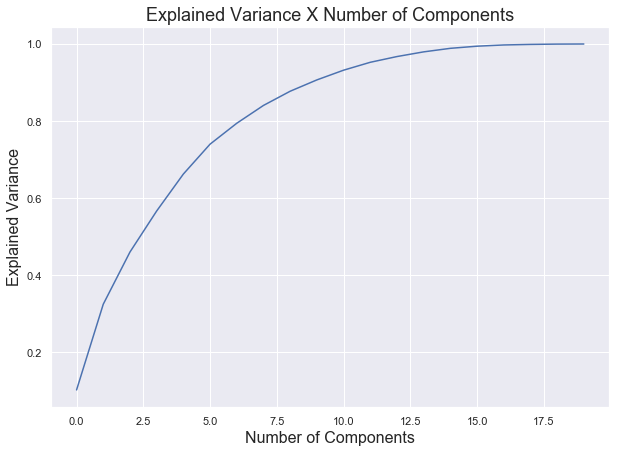

In [266]:
%%time
#Compute explained variance by n_components
variance = []
for i, n in enumerate(np.arange(2,len(X.columns), 10)):
    print("\rFitting PCA {}/19".format(i), end=" ")
    sys.stdout.flush()
    
    pca = PCA(n_components=n)
    pca.fit(X)
    variance.append(pca.explained_variance_ratio_.sum())
    
#Explained Variance Curve 
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(variance)
plt.title('Explained Variance X Number of Components', fontsize=18)
plt.ylabel('Explained Variance', fontsize=16)
plt.xlabel('Number of Components', fontsize=16)
plt.show

In [267]:
def pca_transform(data, pca_components):
    pca = PCA(n_components=pca_components, random_state=0)
    X = pca.fit_transform(data)
    return X

In [268]:
pca_components = 200
X_pca = pca_transform(X, pca_components)

# Baseline Model

In [272]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [281]:
#Creating train, test, split and transforming into XGBoost Matrices
def get_splits(X,y, DMatrix = True):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                      y,
                                      test_size = 0.3,
                                      random_state=0)
    if DMatrix == True:
        D_train = xgb.DMatrix(X_train, label=y_train)
        D_test = xgb.DMatrix(X_test, label=y_test)
        return dtrain, dtest, y_test
    else:
        return X_train, X_test, y_train, y_test

In [273]:
def metrics(y_test, predictions, probabilities):
    cm = confusion_matrix(y_test, predictions)
    auc = round(roc_auc_score(y_test, probabilities), 4)
    fpr = round(100 * (cm[0][1]/(cm[0][0]+cm[0][1])))
    tpr = recall_score(y_test, predictions)
    ppv = precision_score(y_test, predictions)
    return cm, auc, fpr, tpr, ppv

In [274]:
#Dealing with imbalance dataset using ADASYN of Imblearn Package
sm = ADASYN(random_state=0, n_jobs = -1)

In [287]:
%%time
results = {}
count = 0

X_train, X_test, y_train, y_test = get_splits(X_pca, y, DMatrix= False)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

baseline_model = LogisticRegressionCV(cv = 2, penalty= 'l2', n_jobs=-1)
baseline_model.fit(X_train_res, y_train_res)

pred = baseline_model.predict(X_test)
proba = baseline_model.predict_proba(X_test)[:,1]

cm, auc, fpr, tpr, ppv = metrics(y_test, pred, proba)   
results[count] = {"TN": cm[0][0],
                  "FP": cm[0][1],
                  "FN": cm[1][0],
                  "TP": cm[1][1],
                  "AUC": auc,
                  "FPR": fpr,
                  "TPR": tpr,
                  "PPV": ppv
                 }
print("Done.")
sys.stdout.flush()

Done.
Wall time: 2min 43s


In [288]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results = pd.DataFrame(results).T[cols]
df_results

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
0,42052.0,11834.0,1440.0,4674.0,22.0,0.764475,0.283135,0.8547


In [293]:
print("AUC Result: %", round(df_results.AUC.mean(),4))
print("FPR Result: %", round(df_results.FPR.mean(),4))
print("Recall Result: %", round(df_results.TPR.mean(),4))
print("Precision Result: %", round(df_results.PPV.mean(),4))

AUC Result: % 0.8547
FPR Result: % 22.0
Recall Result: % 0.7645
Precision Result: % 0.2831


# XGBoost Model

In [294]:
#Training XGBoost model function
def model_training(dtrain, params, rounds):
    model = xgb.train(dtrain= dtrain, params= params, num_boost_round= rounds)
    return model

In [295]:
#make predictions based on probabilities and a threshold
def get_preds(probabilities, threshold):
    return np.array([1 if x > threshold else 0 for x in probabilities])

## Hyperparameters Optimization

In [296]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

dtrain, dtest, y_test = get_splits(X_pca,y, DMatrix=True)

def objective(space):
    # Instantiate the classifier
    params = {'objective': "binary:logistic",
          'colsample_bytree': space['colsample_bytree'], 
          'gamma': space['gamma'],
          'learning_rate': space['learning_rate'],
          'max_depth': int(space['max_depth']), 
          'min_child': space['min_child_weight'], 
          'reg_alpha': space['reg_alpha'], 
          'scale_pos_weight': space['scale_pos_weight'], 
          'subsample': space['subsample'],
          'tree_method': 'gpu_hist',
          'silent': 1
         }
    
    model = model_training(dtrain, params, 100)

    # Predict probabilities on training set
    probas = model.predict(dtest)
    
    # Calculate our Metric - AUC on testing set
    auc = roc_auc_score(y_test, probas)

    # return loss function.
    return {'loss': -auc, 'status': STATUS_OK }

In [297]:
space ={'max_depth': hp.quniform("max_depth", 2, 16, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'learning_rate': hp.quniform ('learning_rate', 0.01, 0.3, 0.01),
        'subsample': hp.quniform ('subsample', 0.7, 1., 0.01),
        'gamma' : hp.quniform ('gamma', 1,10,1),
        'reg_alpha' : hp.quniform ('reg_alpha', 0.1,1.0,0.05),
        'colsample_bytree' : hp.quniform ('colsample_bytree', 0.01,1,0.01),
        'scale_pos_weight' : hp.quniform('scale_pos_weight', 1,10,0.05),
        'objective': "binary:logistic",
        'tree_method': 'gpu_hist',
        'silent': 1
    }

In [ ]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)
print(best)

 23%|███████████                                     | 115/500 [09:32<19:49,  3.09s/it, best loss: -0.8583980891898769]

In [ ]:
#Getting the best hyperparameters 
def get_best_hyperparameters(best):
    hyperparameters = {'colsample_bytree': 0.06, 
                   'gamma': 6.0,
                   'learning_rate': 0.26,
                   'max_depth': 4,
                   'min_child': 10.0,
                   'reg_alpha': 0.75,
                   'scale_pos_weight': 6.25,
                   'subsample': 0.98,
                   'objective': "binary:logistic",
                   'tree_method': 'gpu_hist',
                   'silent': 1
                  }
    hyperparameters.update(best)
    hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
    return hyperparameters

## Training and Validation

In [ ]:
#Setting up RepeatedStratifiedKFold
splits = 4
repeats = 2
iterations = splits * repeats
rskf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=0)

In [ ]:
%%time

results_xgb = {}
count = 0
for train_index, test_index in rskf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      
    D_train, D_test = get_xgb_matrix(X_train, y_train, X_test, y_test)
    
    model = model_training(D_train, get_best_hyperparameters(best), 2500)
    
    probas = model.predict(D_test)

    preds = get_preds(probas, 0.5)
   
    cm, auc, fpr, tpr, ppv = metrics(y_test, preds, probas)   
    results_xgb[count] = {"TN": cm[0][0],
                      "FP": cm[0][1],
                      "FN": cm[1][0],
                      "TP": cm[1][1],
                      "AUC": auc,
                      "FPR": fpr,
                      "TPR": tpr,
                      "PPV": ppv
                     }
    count += 1
    print("\rTraining. {}/{}".format(count,iterations), end=" ")
    sys.stdout.flush()

In [ ]:
df_results_xgb = pd.DataFrame(results_xgb).T[cols]
df_results_xgb

In [ ]:
df_results_xgb.describe()

In [ ]:
axes = df_results_xgb[["FPR","TPR","PPV","AUC"]].plot(subplots=True, layout=(2,2), figsize = (10,10))
type(axes)

In [ ]:
print("Average AUC Result: %", round(df_results_xgb.AUC.mean(),4))
print("Average FPR Result: %", round(df_results_xgb.FPR.mean(),4))
print("Average TPR Result: %", round(df_results_xgb.TPR.mean(),4))
print("Average PPV Result: %", round(df_results_xgb.PPV.mean(),4))

## Feature Importances

In [ ]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
ceate_feature_map(X)

In [ ]:
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore_ratio'] = df['fscore'] / df['fscore'].sum()
feat_imp = df.sort_values(by=['fscore'],ascending=False )
feat_imp

In [ ]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
my_plot_importance(model, (15,60))

## Model ROC Curve

In [ ]:
roc_values = []
for thresh in np.linspace(0, 1, 101):
    preds = get_preds(probas, thresh)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

# Submission

In [ ]:
def transform_data(data):
    final_data = data.drop(['ID_code'], axis = 1)
    #final_data = xgb.DMatrix(final_data)
    return final_data

In [ ]:
def make_csv(test_data, model):
    preds_final = model.predict(test_data)
    predictions = pd.Series(preds_final, index = test['ID_code'], name = 'target')
    return predictions.to_csv("submission.csv", header = True)

In [ ]:
dtrain, dtest, y_test = get_splits(X_pca,y, DMatrix=True
model = model_training(dtrain, get_best_hyperparameters(best), 2500)

In [ ]:
test_data = transform_data(test)
test_data

In [ ]:
make_csv(test_data, model)